In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import dataframe_image as dfi
from shapely import wkt
import sys
# !{sys.executable} -m pip install contextily
import contextily as ctx 

/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
FilePath = '/Users/hoperuse/summer2021internship/State Surplus/final_data.csv' # Replace with your own file path to csv of DOT parcels

# Data - Pandas DataFrame holding all parcel data in the final data universe, dropping leftover garbarge index columns
#   Setting index to mapc_id, a unique identifier for each parcel, to be used to match walkscore data
data = pd.read_csv(FilePath, index_col='mapc_id').drop(columns=['Unnamed: 0', 'index'])

# Removing the word "District" from the column holding the name of the corresponding districts for each parcel
# to prep for geomerge with State House district lines shapefile.
data['District'] = data['District'].str.replace(' District','')

# Adding null transit, walk, and bike score columns to be filled via the update function
data['TransitScore'] = np.nan
data['WalkScore'] = np.nan
data['BikeScore'] = np.nan

# Walkscores - Pandas DataFrame holding previously collected walk, bike, and transit score data for each parcel, which is then matched to each parcel
#   via the mapc_id field
walkscores = pd.read_csv('https://raw.githubusercontent.com/hochru557/summer2021internship/master/State%20Surplus/TransitScoresCompressed.csv',index_col='mapc_id')

# Updating data columns for scores using values from walkscore
data.update(walkscores)

# Reset index to normal, and returning mapc_id field to its original location
data = data.reset_index()

# Vacant - filtered dataset of just those parcels with land use codes of 973 (vacant, DOH) and 975 (vacant, DOT)
vacant = data[data['luc_adj_2'].isin([973,975])] 

In [3]:
# Creating a summary dataframe with overview data on data parcels, to be exported as .png file
summary = pd.DataFrame(columns = ['Categorization','Total Number of Parcels', 'Total Land Value'])
summary.at[0,'Categorization'] = 'All Parcels'
summary.at[0, 'Total Number of Parcels'] = len(data.index)
summary.at[0, 'Total Land Value'] = data.land_value.sum()

summary.at[1,'Categorization'] = 'Vacant DOH/DOT'
summary.at[1, 'Total Number of Parcels'] = len(vacant.index)
summary.at[1, 'Total Land Value'] = vacant.land_value.sum()
summary

# dfi.export(summary,'summary.png')

,Categorization,Total Number of Parcels,Total Land Value
0,All Parcels,14274,7.25884e+09
1,Vacant DOH/DOT,599,1.93004e+08


In [4]:
# parcelsAgg: a dataframe to hold aggregate information on each districts total DOT-owned parcels
parcelsAgg = pd.DataFrame(columns=['District','NumParcels','LandValue','AvgValue','TotalAreaFt', 'AvgArea','NumTransitFriendly','AvgWalkScore'])

# List of all unique values for District from the original dot dataframe, to be iterated through in populating 
# the parcelsAgg dataframe
districts = data['District'].unique().flatten()

for district in districts:
    # df - Filtered dataframe for the current value of district
    df = data[data['District'] == district]
    parcelsAgg.loc[district,'NumParcels'] = len(df.index)
    parcelsAgg.loc[district,'LandValue'] = df.land_value.sum()
    parcelsAgg.loc[district,'AvgValue'] = df.land_value.mean()
    parcelsAgg.loc[district,'TotalAreaFt'] = df.lot_areaft.sum()
    parcelsAgg.loc[district,'AvgArea'] = df.lot_areaft.mean()
    parcelsAgg.loc[district,'NumTransitFriendly'] = len(data[data.numTransitStops.notna()])
    parcelsAgg.loc[district,'AvgWalkScore'] = df.WalkScore.mean()
    
parcelsAgg = parcelsAgg.reset_index()
parcelsAgg = parcelsAgg.drop(columns=['District'])
parcelsAgg = parcelsAgg.rename(columns={'index':'District'})
parcelsAgg = parcelsAgg.dropna()

In [5]:
# Creating image files for top 10 House Districts sorted on different measures regarding their contained 
# DOT owned parcels
pd.options.display.float_format = '{:20,.2f}'.format

# TOP 10 DISTRICTS BY TOTAL NUMBER OF DOT OWNED PARCELS
df = parcelsAgg.sort_values(by='NumParcels',ascending=False).head(10).reset_index(drop=True)
df= df[['District', 'NumParcels']]
dfi.export(df,'/Users/hoperuse/summer2021internship/State Surplus/Graphics/topNumParcels.png')

# TOP 10 DISTRICTS BY TOTAL VALUE OF ALL STATE OWNED PARCELS
df=parcelsAgg.sort_values(by='LandValue',ascending=False).head(10).reset_index(drop=True)
df= df[['District', 'LandValue','AvgValue']]
dfi.export(df,'/Users/hoperuse/summer2021internship/State Surplus/Graphics/topLandValue.png')

# TOP 10 DISTRICTS  BY AVERAGE STATE OWNED PARCEL VALUE
df=parcelsAgg.sort_values(by='AvgValue',ascending=False).head(10).reset_index(drop=True)
df= df[['District', 'AvgValue','LandValue']]
dfi.export(df,'/Users/hoperuse/summer2021internship/State Surplus/Graphics/topAvgValue.png')

df=parcelsAgg.sort_values(by='TotalAreaFt',ascending=False).head(10).reset_index(drop=True)
df= df[['District', 'TotalAreaFt','AvgArea']]
dfi.export(df,'/Users/hoperuse/summer2021internship/State Surplus/Graphics/topTotalArea.png')


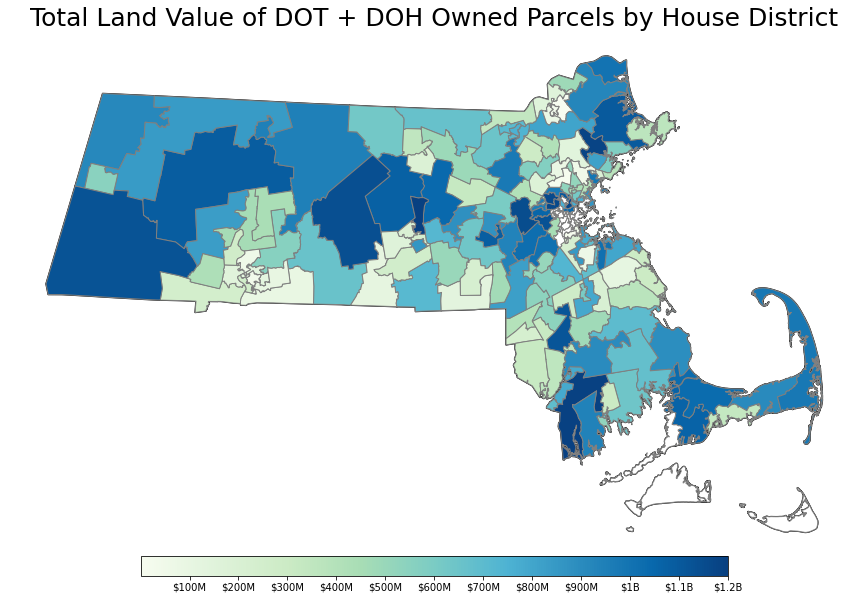

In [7]:
# MA House Leg Districts (https://www.mass.gov/info-details/massgis-data-massachusetts-house-legislative-districts#downloads-)
houseDistricts = gpd.read_file('/Users/hoperuse/summer2021internship/State Surplus/house2012/HOUSE2012_POLY.shp')

# Rename District column to match name in houseDistricts file
parcelsAgg = parcelsAgg.rename(columns = {'District': 'REP_DIST'})

# Geospatial merge of parcelsAgg and houseDistricts for mapping
merged = houseDistricts.merge(parcelsAgg, on = 'REP_DIST', how='left')

# Mapping total value of all parcels by House district
fig, ax = plt.subplots(figsize=(20,10))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(parcelsAgg['LandValue']), 1200000000
merged.plot(column='LandValue',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        missing_kwds = {"color":"white"})
ax.axis('off')
ax.set_title('Total Land Value of DOT + DOH Owned Parcels by House District',fontdict={'fontsize': '25', 'fontweight' : '3'})

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin,vmax=vmax))
cbar = fig.colorbar(sm, ticks=[100000000,200000000,300000000,400000000,500000000,600000000,700000000,800000000,900000000,1000000000,1100000000,1200000000],orientation="horizontal", fraction=0.036, pad=0, aspect = 30)
cbar.ax.set_xticklabels(['$100M', '$200M', '$300M','$400M','$500M','$600M','$700M','$800M','$900M','$1B','$1.1B','$1.2B'])  # horizontal colorbar

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/LandValueDOT.jpg',dpi=300)

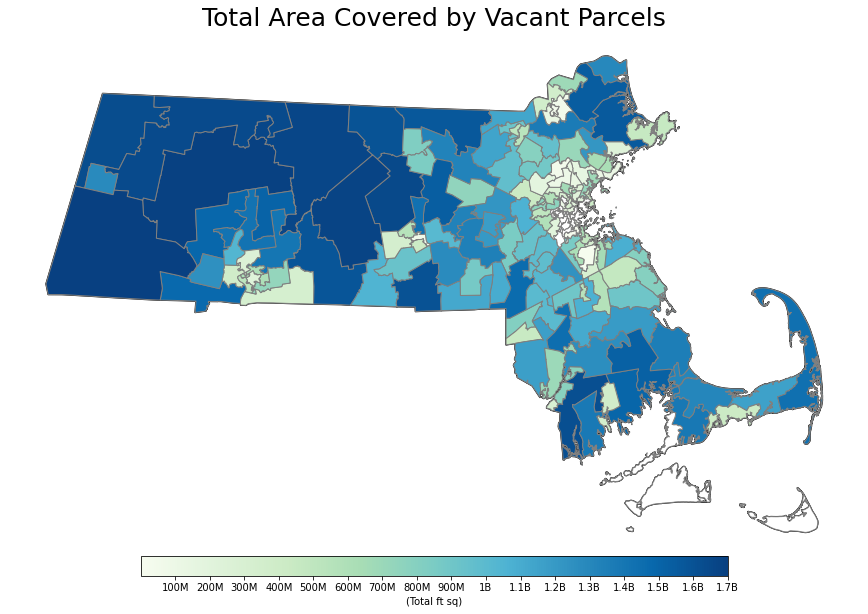

In [8]:
# Mapping total area (square feet) of state owned parcels by district
pd.options.display.float_format = '{:20,.2f}'.format

fig, ax = plt.subplots(figsize=(20,10))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(parcelsAgg.TotalAreaFt), 1700000000
merged.plot(column='TotalAreaFt',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        missing_kwds = {"color":"white"})
ax.axis('off')
ax.set_title('Total Area Covered by Vacant Parcels',fontdict={'fontsize': '25', 'fontweight' : '3'})

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin,vmax=vmax))
cbar=fig.colorbar(sm, ticks=[100000000,200000000,300000000,400000000,500000000,600000000,700000000,800000000,900000000,1000000000,1100000000,1200000000,1300000000,1400000000,1500000000,1600000000,1700000000],orientation="horizontal", fraction=0.036, pad=0, aspect = 30)
cbar.ax.set_xticklabels(['100M', '200M', '300M','400M','500M','600M','700M','800M','900M','1B','1.1B','1.2B','1.3B','1.4B','1.5B','1.6B','1.7B'])
cbar.set_label("(Total ft sq)")  # horizontal colorbar

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/TotalArea.jpg',dpi=300)

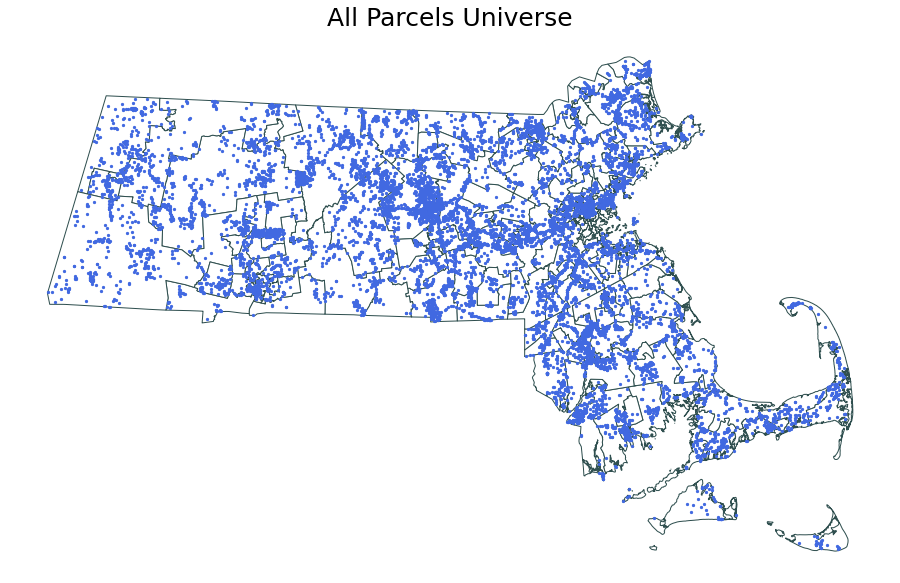

In [9]:
# MAPPING ALL STATE OWNED LAND PARCELS

# Converting final_data into a GeoPandas DataFrame
geometry = data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(data,geometry=geometry,crs = 'EPSG:26986') # Matching the new gdf crs to the crs of houseDistricts
gdf['geometry'] = gdf['geometry'].centroid

fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
base = houseDistricts.plot(ax=ax, color='white', edgecolor='darkslategrey')

gdf.plot(ax=ax, marker='o', color='royalblue', markersize=5,legend=False)
ax.axis('off')
ax.set_title('All Parcels Universe',fontdict={'fontsize': '25', 'fontweight' : '3'})

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/AllParcels.png',dpi=300)

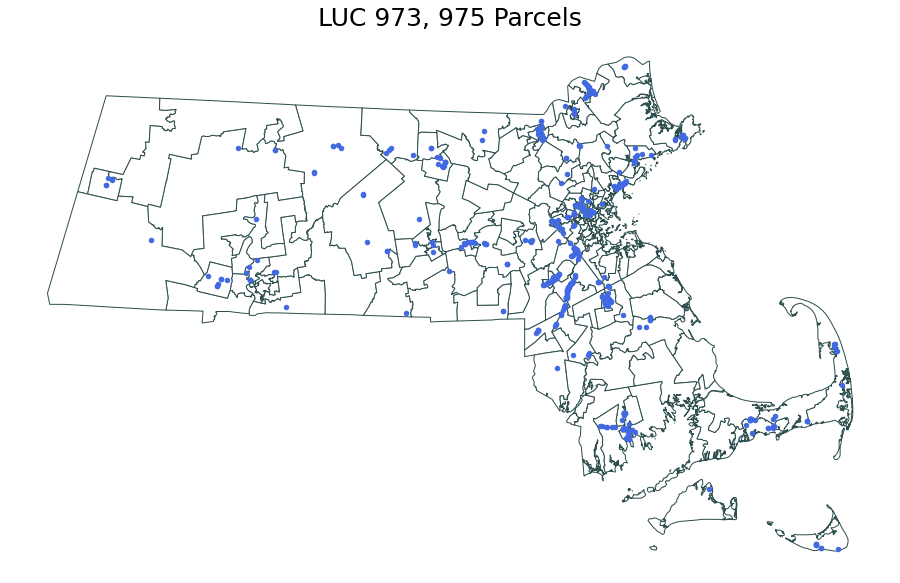

In [10]:
# MAPPING ALL VACANT (973, 975) STATE OWNED PARCELS ACROSS MA

# Converting final_data into a GeoPandas DataFrame
vacant = data[data.luc_adj_2.isin([973,975])]
vMap = gpd.GeoDataFrame(vacant,geometry=geometry,crs = 'EPSG:26986') # Matching the new gdf crs to the crs of houseDistricts
vMap.geometry = vMap.geometry.centroid

fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
base = houseDistricts.plot(ax=ax, color='white', edgecolor='darkslategrey')

vMap.plot(ax=ax, marker='o', color='royalblue', markersize=20,legend=False)
ax.axis('off')
ax.set_title('LUC 973, 975 Parcels',fontdict={'fontsize': '25', 'fontweight' : '3'})

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/VacantParcels.png',dpi=300)

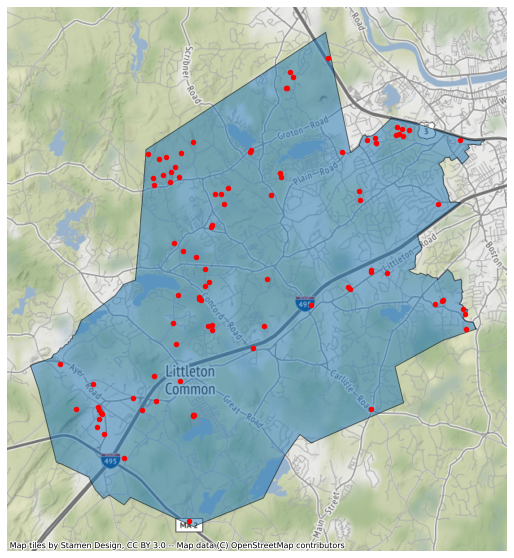

In [11]:
# Analysis specific to Chair Arceiro's District
arceiro = houseDistricts[houseDistricts.REP_DIST == '2nd Middlesex']
arceiro = arceiro.to_crs(epsg=3857)

ax = arceiro.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

arceiro1 = gdf[gdf.District == '2nd Middlesex']
arceiro1 = arceiro1.to_crs(epsg=3857)

arceiro1.plot(ax=ax, marker='o', color='red', markersize=20,legend=False,zorder=3)
ctx.add_basemap(ax,zoom=12)
ax.set_axis_off()

plt.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/Arceiro.png')
